In [28]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm
from pytorch_fid import fid_score
from torchvision.models.inception import inception_v3
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import kagglehub
import os
import numpy as np


In [29]:
# import shutil
# shutil.rmtree(r"C:\Users\vgor\.cache\kagglehub\datasets\jessicali9530\celeba-dataset")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# os.chmod(path, 0o755)


In [30]:
# Step 1: Set up Hyperparameters
nz = 100 
batch_size = 64
lr = 0.0002
beta1 = 0.5
epochs = 150
num_classes = 40



Step 2: Load and Preprocess CelebA Dataset
This step involves preparing the CelebA dataset for training by defining a custom PyTorch Dataset class, applying image transformations, and loading the data using a DataLoader.

CelebADataset Custom Class
Inherits from torch.utils.data.Dataset.

Takes a DataFrame of attributes, a path to the image directory, and an optional transform pipeline.

Implements:

__len__: Returns total number of samples.

__getitem__: Loads an image by filename, applies transforms, and extracts attribute labels as float tensors.

Image Preprocessing
Using torchvision.transforms, each image undergoes:

Resize(64): Rescales image to 64×64 pixels.

CenterCrop(64): Ensures centered square crop (safe for non-square inputs).

ToTensor(): Converts PIL Image to a PyTorch tensor.

Normalize([0.5]*3, [0.5]*3): Normalizes image to [-1, 1] range (standard for GAN training).

Load Attributes and Images
CSV: Loads list_attr_celeba.csv, which contains binary labels for 40 facial attributes.

Image Directory: Points to aligned CelebA face images (img_align_celeba).

DataLoader Setup
Wraps the custom dataset with PyTorch DataLoader:

Batching with specified batch_size.

Shuffling enabled for better training generalization.

In [31]:
# Step 2: Load and Preprocess Dataset

from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
class CelebADataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        attrs = self.df.iloc[idx, 1:].values.astype(np.float32)
        attrs = torch.tensor(attrs, dtype=torch.float32)

        return image, attrs

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

df = pd.read_csv(r"C:\Users\vgor\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\list_attr_celeba.csv")  
image_dir = r"C:\Users\vgor\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba"


dataset = CelebADataset(df, image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)





The Generator class is a fully connected neural network designed to produce realistic 64×64 RGB face images conditioned on facial attributes using the CelebA dataset.

Architecture Overview
Input: Concatenated noise vector z (latent space) and attribute vector attr.

Layers:

Linear Layers progressively expand the feature dimension: (nz + attr_dim) → 256 → 512 → 1024 → 64×64×3.

LeakyReLU activations allow small gradient flow for negative values, promoting stable training.

Tanh activation on the final layer scales pixel values to [-1, 1], matching image normalization.

Reshape: Output is reshaped to image format (batch_size, 3, 64, 64).

Forward Pass
Concatenates noise and attribute vectors.

Passes through the sequential model to generate a synthetic image.

This setup enables conditional image generation—producing faces that match specific attribute labels.



In [32]:
# Step 3: Generator


class Generator(nn.Module):
    def __init__(self, nz, attr_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(nz + attr_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, z, attr):
        gen_input = torch.cat((z, attr), dim=1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 3, 64, 64)
        return img



The Discriminator is a fully connected neural network that evaluates whether an input image is real or generated, conditioned on attribute labels.

Architecture Overview
Input:

A 64×64×3 image (flattened) and

A corresponding attribute vector (size 40).

Label Embedding: Uses an embedding layer to represent categorical labels (if needed), but here the attributes are already provided as a 40-dimensional vector.

Layers:

Concatenates the flattened image and attribute vector → total input size is 64×64×3 + 40.

A series of Linear layers reduce dimensionality with LeakyReLU activations, ending in a Sigmoid output for binary classification (real vs fake).

Forward Pass
The image is flattened and concatenated with the attribute vector.

The combined vector is passed through the model to output a validity score (between 0 and 1), representing the likelihood that the input image is real and matches the given attributes.

In [33]:
# Step 4: Discriminator

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 40)  # Assuming 40 attributes
        
        self.model = nn.Sequential(
            nn.Linear(64 * 64 * 3 + 40, 1024),  # Correct concatenation size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, attr):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        attr_flat = attr.view(attr.size(0), -1)  # Flatten the attributes (make sure attr is a vector of size 40)

        d_input = torch.cat((img_flat, attr_flat), dim=1)  # Concatenate image and attribute vectors
        

        return self.model(d_input)






In [34]:
# Step 5: Initialize Models and Set Optimizers
generator = Generator(nz, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)


optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
loss_fn = nn.BCELoss()

The training process follows the standard GAN routine but includes attribute conditioning for both the Generator and Discriminator.

Data Preparation
Images (imgs) and attribute vectors (attr_vectors) are loaded from the custom CelebA dataloader.

Attribute vectors are cast to float and moved to the same device as the model (GPU or CPU).

Discriminator Training
The Discriminator is trained to:

Output ~1.0 (real) for true images with correct attributes.

Output ~0.0 (fake) for synthetic images paired with the same attributes.

Uses label smoothing (0.9 for real, 0.1 for fake) to improve training stability.

Gradients are computed and weights updated.

Generator Training
The Generator is trained to fool the Discriminator:

Generates images from noise and attributes.

The Discriminator’s output for these fake images is compared against real labels (1.0) to encourage realism.

Again, gradients are computed and weights updated.

Logging
Every 200 batches, it prints:

The current epoch and batch

Discriminator loss (D Loss)

Generator loss (G Loss)

This process encourages the Generator to produce more attribute-consistent, realistic face images, while the Discriminator becomes more discerning.



In [35]:
# Training Loop

for epoch in range(epochs):
    for i, (imgs, attr_vectors) in enumerate(dataloader):
        imgs = imgs.to(device)
        attr_vectors = attr_vectors.float().to(device)  # Make sure it's float32 for concat


        batch_size = imgs.size(0)
        
        # ======================
        #  Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        # Real images
        real_validity = discriminator(imgs, attr_vectors)
        real_loss = loss_fn(real_validity, torch.full((batch_size, 1), 0.9).to(device))  # Label smoothing

        # Fake images
        z = torch.randn(batch_size, nz).to(device)
        gen_imgs = generator(z, attr_vectors)
        fake_validity = discriminator(gen_imgs.detach(), attr_vectors)
        fake_loss = loss_fn(fake_validity, torch.full((batch_size, 1), 0.1).to(device))

        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # ======================
        #  Train Generator
        # ======================
        optimizer_G.zero_grad()

        # Recompute gen_imgs since discriminator params have changed
        gen_validity = discriminator(gen_imgs, attr_vectors)
        g_loss = loss_fn(gen_validity, torch.ones(batch_size, 1).to(device))

        g_loss.backward()
        optimizer_G.step()
        

        # ======================
        # Logging
        # ======================
        if i % 200 == 0:
            print(f"Epoch {epoch}/{epochs} Batch {i}/{len(dataloader)} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")





Epoch 0/150 Batch 0/3166 | D Loss: 1.3872 | G Loss: 0.7336
Epoch 0/150 Batch 200/3166 | D Loss: 0.7097 | G Loss: 2.3077
Epoch 0/150 Batch 400/3166 | D Loss: 0.8697 | G Loss: 1.4073
Epoch 0/150 Batch 600/3166 | D Loss: 0.9691 | G Loss: 1.6179
Epoch 0/150 Batch 800/3166 | D Loss: 0.9410 | G Loss: 1.7130
Epoch 0/150 Batch 1000/3166 | D Loss: 0.9881 | G Loss: 1.5772
Epoch 0/150 Batch 1200/3166 | D Loss: 0.9976 | G Loss: 1.2966
Epoch 0/150 Batch 1400/3166 | D Loss: 1.1307 | G Loss: 1.8724
Epoch 0/150 Batch 1600/3166 | D Loss: 1.0414 | G Loss: 1.4570
Epoch 0/150 Batch 1800/3166 | D Loss: 1.0379 | G Loss: 1.6378
Epoch 0/150 Batch 2000/3166 | D Loss: 1.0576 | G Loss: 1.6241
Epoch 0/150 Batch 2200/3166 | D Loss: 1.1451 | G Loss: 1.4539
Epoch 0/150 Batch 2400/3166 | D Loss: 1.1069 | G Loss: 1.5102
Epoch 0/150 Batch 2600/3166 | D Loss: 1.1629 | G Loss: 1.4372
Epoch 0/150 Batch 2800/3166 | D Loss: 1.1152 | G Loss: 1.2238
Epoch 0/150 Batch 3000/3166 | D Loss: 1.1513 | G Loss: 1.0645
Epoch 1/150 Bat

In [36]:
attribute_cols = [col for col in df.columns if col != 'image_id']

# Convert -1 to 0 in the attribute columns
df[attribute_cols] = (df[attribute_cols] + 1) // 2

# Create mapping of attribute name to index (optional but useful)
attribute_mapping = {name: idx for idx, name in enumerate(attribute_cols)}


C:\Users\vgor\AppData\Local\Temp\ipykernel_26456\2584888641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))


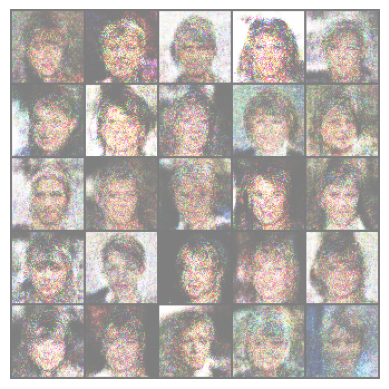

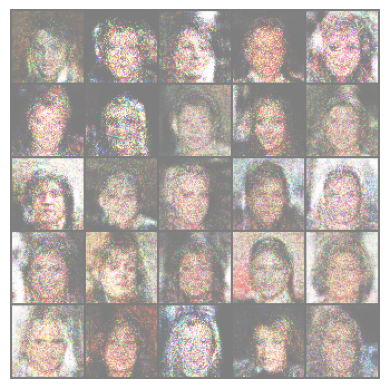

In [71]:
# Save and load the model
torch.save(generator.state_dict(), 'generator.pth')
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Step 6: Function to load and generate new images

def show_generated_images(images, num_images=25):
    grid = vutils.make_grid(images, nrow=5, normalize=True, value_range=(-1, 1))
    grid = (grid + 1) / 2
    grid = grid.cpu()  # Move to CPU for visualization
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()
# Create attribute mapping (skip 'image_id' column)
attribute_mapping = {attribute: index for index, attribute in enumerate(df.columns[1:])}

def generate_images_for_attribute(attribute_name, num_images=25):
    if attribute_name not in attribute_mapping:
        raise ValueError(f"Attribute '{attribute_name}' not found in the dataset.")
    
    # Create labels (you already have the mapping)
    labels = torch.full((num_images,), attribute_mapping[attribute_name], dtype=torch.long).to(device)

    
    # Expand the labels to one-hot encoding (if needed) or keep it as is
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=40).float().to(device) 

    # Generate random latent vectors
    z = torch.randn(num_images, nz).to(device)

    # Generate the images based on the conditional labels
    with torch.no_grad():
        generated_images = generator(z, one_hot_labels)  # Pass separate z and one_hot_labels

    # Show the generated images
    show_generated_images(generated_images, num_images=num_images)
    return generated_images


generated_faces = generate_images_for_attribute("Bangs", num_images=25)


generated_faces1 = generate_images_for_attribute("Straight_Hair", num_images=25)



In [45]:

# Step 7: Calculate FID Score

# Save real and fake images to temporary directories
def save_images_to_directory(images, directory):
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        save_image(img, os.path.join(directory, f"image_{i}.png"), normalize=True)

# Calculate FID using pytorch_fid
def calculate_fid_with_pytorch_fid(real_images, fake_images, batch_size=64, device="cuda"):
    real_dir = "temp_real"
    fake_dir = "temp_fake"

    # Save real and fake images to temporary directories
    save_images_to_directory(real_images, real_dir)
    save_images_to_directory(fake_images, fake_dir)

    # Calculate FID
    fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir], batch_size=batch_size, device=device, dims=2048)

    # Clean up temporary directories
    for img_file in os.listdir(real_dir):
        os.remove(os.path.join(real_dir, img_file))
    for img_file in os.listdir(fake_dir):
        os.remove(os.path.join(fake_dir, img_file))
    os.rmdir(real_dir)
    os.rmdir(fake_dir)

    return fid_value

def generate_images(generator, num_images=25, labels=None):
    generator.eval()
    z = torch.randn(num_images, nz).to(device)
    
    if labels is None:
        labels = torch.randint(0, num_classes, (num_images,)).to(device)

    # Convert labels to one-hot encoding
    labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

    with torch.no_grad():
        gen_imgs = generator(z, labels)
    
    return gen_imgs.cpu()


# Generate fake images
generated_images = generate_images(generator, num_images=10000)  # Generate 1000 fake images

# Load real images from the dataloader
real_images = []
for imgs, _ in dataloader:
    real_images.append(imgs)
    if len(real_images) * batch_size >= 10000:
        break
real_images = torch.cat(real_images, dim=0)[:10000]

# Calculate FID score
fid_value = calculate_fid_with_pytorch_fid(real_images, generated_images, batch_size=64, device=device)
print(f"FID Score: {fid_value:.4f}")


100%|██████████| 157/157 [00:44<00:00,  3.52it/s]


FID Score: 294.8096
